En este archivo se explica e implementa el proceso de calcular las líneas del carríl por el que va nuestro coche

In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

CWD = os.getcwd()
PATH_CITYSCAPE_DATA = os.path.join(CWD, 'datasets/cityscape_data')
PATH_IMAGES = os.path.join(CWD, "display_elements/road_segmentation/images")
PATH_VIDEOS = os.path.join(CWD, "display_elements/road_segmentation/videos")
PATH_RESULT_IMAGES = os.path.join(CWD, "results/road_segmentation/images")
PATH_RESULT_VIDEOS = os.path.join(CWD, "results/road_segmentation/videos")

try:
    os.mkdir(PATH_RESULT_IMAGES)
    os.mkdir(PATH_RESULT_VIDEOS)
except FileExistsError:
    pass

print(f"Dataset: {PATH_CITYSCAPE_DATA}")
print(f"Images: {PATH_IMAGES}")
print(f"Videos: {PATH_VIDEOS}")
print(f"Resulting images: {PATH_RESULT_IMAGES}")
print(f"Resulting videos: {PATH_RESULT_VIDEOS}")

Dataset: c:\Users\gonza\Desktop\universidad\Malaga\Tercero\Vision\Trabajo_Opcional\ADAS-car-distance-prediction\car-distance-prediction\datasets/cityscape_data
Images: c:\Users\gonza\Desktop\universidad\Malaga\Tercero\Vision\Trabajo_Opcional\ADAS-car-distance-prediction\car-distance-prediction\display_elements/road_segmentation/images
Videos: c:\Users\gonza\Desktop\universidad\Malaga\Tercero\Vision\Trabajo_Opcional\ADAS-car-distance-prediction\car-distance-prediction\display_elements/road_segmentation/videos
Resulting images: c:\Users\gonza\Desktop\universidad\Malaga\Tercero\Vision\Trabajo_Opcional\ADAS-car-distance-prediction\car-distance-prediction\results/road_segmentation/images
Resulting videos: c:\Users\gonza\Desktop\universidad\Malaga\Tercero\Vision\Trabajo_Opcional\ADAS-car-distance-prediction\car-distance-prediction\results/road_segmentation/videos


## Eliminar perspectiva

El primer paso para la segmentación del carril, es eliminar la perspectiva que presenta la imagen, y dejar el carril "visto desde arriba". Para ello, se debe averiguar la homografía que hay que aplicar.

Para poder aproximar una homografía común a todas las imágenes de carretera, se analizará una imagen de muestra de una carretera recta. En esta imagen, se va a suponer que existe un rectángulo alineado con las líneas del carril, que se utilizará para averiguar la homografía que corregirá la perspectiva.

A continuación se muestra la imagen de muestra extraída del videojuego GTA V, con el rectángulo imaginario dibujado sobre la carretera.

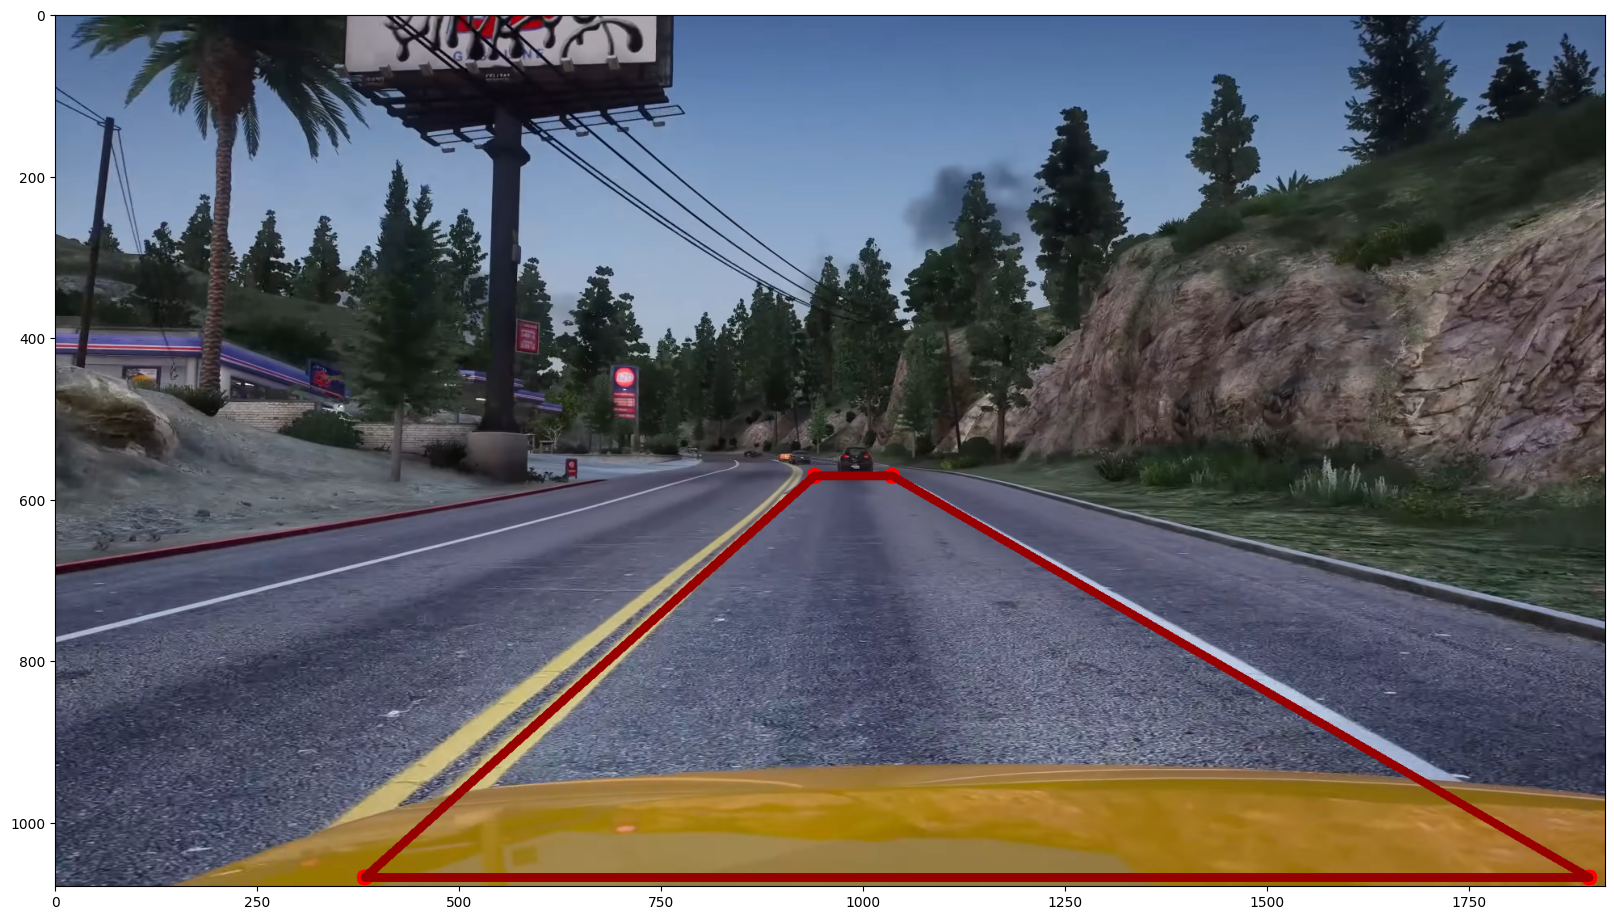

In [2]:
# Get the road image
image_name = "gta_road1.png"
img_path = os.path.join(PATH_IMAGES, image_name)
image = cv2.imread(img_path)

# Image height and width
img_h, img_w = image.shape[:2]

# Define the rectangle for the image perspective
p1_top_left = (int(img_w * 0.49), int(img_h * 0.53)) 
p2_top_right = (int(img_w * 0.54), int(img_h * 0.53)) 
p3_bot_right = (int(img_w * 0.99), int(img_h * 0.99)) 
p4_bot_left  = (int(img_w * 0.2), int(img_h * 0.99)) 

src_pts = np.float32([p1_top_left, p2_top_right, p3_bot_right, p4_bot_left])
draw_pts = src_pts.astype(int)

for point in draw_pts:
    cv2.circle(image, (point[0], point[1]), 10, (0, 0, 255), -1)

image = cv2.line(image, tuple(draw_pts[0]), tuple(draw_pts[1]),thickness=10,color=[0,0,150])
image = cv2.line(image, tuple(draw_pts[0]), tuple(draw_pts[3]),thickness=10,color=[0,0,150])
image = cv2.line(image, tuple(draw_pts[1]), tuple(draw_pts[2]),thickness=10,color=[0,0,150])
image = cv2.line(image, tuple(draw_pts[2]), tuple(draw_pts[3]),thickness=10,color=[0,0,150])

plt.figure(figsize=(20, 14))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

A continuación, se implementa un método que transforma la perspectiva de la carretera, para dejarla en "vista de pájaro".

In [3]:
def remove_road_perspective(img, 
                            src_pts = np.float32([(0.47,0.55), 
                                                  (0.56, 0.55), 
                                                  (0.95, 0.95), 
                                                  (0.2, 0.95)])
                            ):
    """
        This method calculate the homography of the road, given the points of a rectangle aling with straight road lines
    Args:
        img: The road image from the camera perspective
        src_pts: The points of a rectangle align with the road lines in the image. In case its not given, it will be aproximated
                    by a default rectangle taken from a dashboard camera.

    Returns:
        no_perspective_image: The image with removed perspective, like seen from above
        M: The homography matrix calculated for removing perspective
    """
    
    img_h, img_w = image.shape[:2]
    print(f"Image size: {img_w}x{img_h}")

    dst_pts = np.float32([(int(img_w*0.4), 300), 
                          (int(img_w*0.6), 300), 
                          (int(img_w*0.6), img_h), 
                          (int(img_w*0.4), img_h)
                        ])
    
    M = cv2.getPerspectiveTransform(src_pts, dst_pts)
    
    no_perspective_image = cv2.warpPerspective(img, M, (img_w, img_h), flags=cv2.INTER_LINEAR)

    return no_perspective_image, M

Procedemos ahora a aplicar la homografía a la imagen anterior. Se muestra el rectángulo para verificar la aplicación de la homografía

Image size: 1919x1079


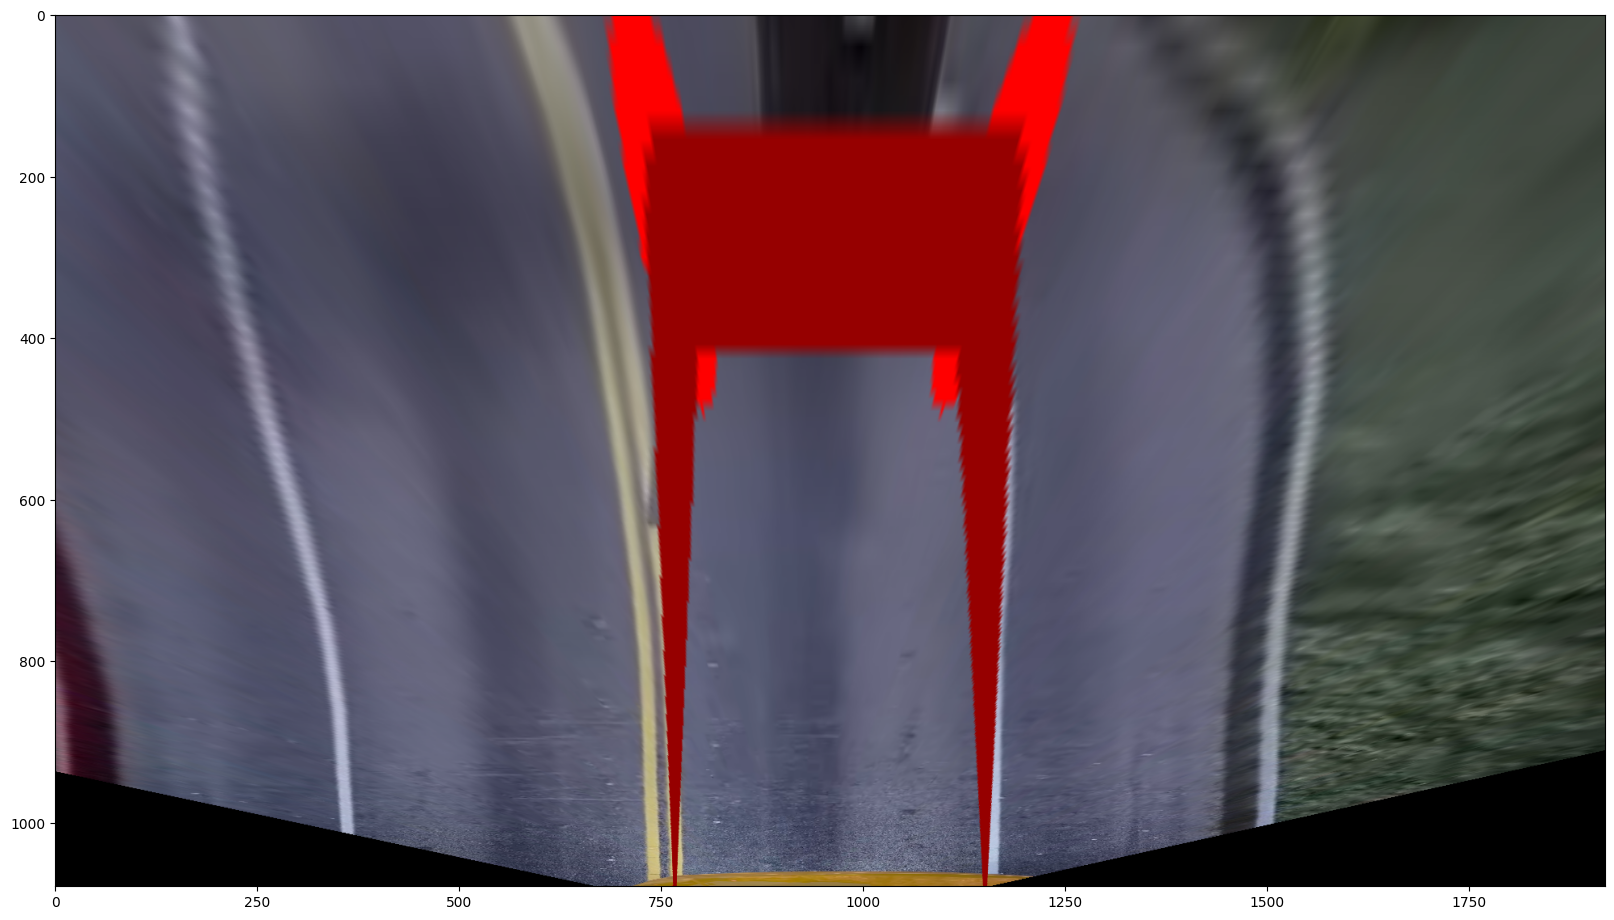

In [20]:
no_perspective, M = remove_road_perspective(image, src_pts)

plt.figure(figsize=(20, 14))
plt.imshow(no_perspective)

Como se puede observar, la homografía ha rectificado las líneas de la carretera correctamente. La desventaja de este método, es que solo rectificará a la perfección imagenes tomadas con esta misma perspectiva. Para aplicar la homografía a cualquier imagen tomada desde una perspectiva distinta, es necesario pasar como parámetro los puntos de un rectángulo alineado con las líneas de carretera para dicha camara.

## Detección de líneas

Una vez aplicada la homografía, se deben detectar las líneas de la carretera. Para ello se utilizará el supuesto de que las líneas de la carretera tienen un alto contraste con el asfalto. Por tanto, se puede emplear el algoritmo de Canny para detectar la imagen de gradientes del eje X, y así poder extraer las rectas, que están orientadas hacia el eje Y.